# 11762 Content-Based Image Retrieval
## Master's Degree in Intelligent Systems
### University of the Balearic Islands

---

In [2]:
# Setup code for this assignment
import cv2
import math
import numpy as np
import os
import scipy.cluster.vq as vq
import tqdm
import zipfile

## Adding parent folder to find other libs
import sys
if ".." not in sys.path:
    sys.path.insert(0,"..")
    
import iric_utils.eval_holidays as ev
import iric_utils.read_descriptors as rd

# Configuring Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Introduction
---
The main goal of this assigment is to implement a complete CBIR system using VLAD, as image descriptor, in combination with Product Quantization (PQ), as indexing method. You will also experiment with a simple search reranking method.

In this assigment, images will be described using the following steps:
- Load a set of SIFT features for each image.
- Aggregate these features into a VLAD vector.
- (Optionally) Apply dimensionality reduction using PCA.

Next, using the computed VLAD vectors, an index of images will be built by using PQ:
- Build a set of quantizers (small vocabularies).
- Encode database images using these quantizers.
- Search query images in the index using the Asymmetric Distance Computation (ADC) approach to measure the system performance.

As usual during this course, we will use the [INRIA Holidays](http://lear.inrialpes.fr/people/jegou/data.php) dataset. **Check previous assignments to further information about this dataset.**

We also need the provided script to evaluate a CBIR system on this dataset. Remember that the performance is measured computing the **mean average precision** (mAP) over all queries. **Check also previous assignments to remember how to use this script and the different functions it offers.**

### Loading images
As we did in previous assignments, for managing images, we will create four lists:
- **`query_names`**: File names of the *query* images
- **`query_imgs`**: *Query* images loaded using OpenCV
- **`train_names`**: File names of the *train* (database) images
- **`train_imgs`**: *Train* images loaded using OpenCV

In this assignment, we will use the original INRIA Holidays dataset:

In [3]:
# Separating the dataset into query and train images
query_names = []
query_imgs = []
train_names = []
train_imgs = []

with open('../holidays/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
        img = cv2.imread('../holidays/images/' + imname)
        # Resize the images for a faster operation in this assignment
        img = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    
        # Checking if this is a query image
        if imno % 100 == 0:
            query_names.append(imname)
            query_imgs.append(img)
        else:
            train_names.append(imname)
            train_imgs.append(img)

print(len(query_names))
print(len(train_names))

500
991


## Loading SIFT descriptors
In this assignment we will create four additional lists:
- **`query_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *query* images
- **`query_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *query* images
- **`train_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *train* (database) images
- **`train_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *train* images

As we did in Assigment 2, you are provided with a set of SIFT descriptors for each image, and, therefore, you do not need to create these lists from scratch. If you do no have these descriptors in your computer, first, download them from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_es/Eam8Ld8YDaJAhNr91YVdAZIB_wVZJ8kzzKD7BR6R3LziMw).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

Remember that these descriptors are in a directory called `siftgeo` that should be in your workspace, containing the set of SIFT descriptors for each image of the dataset. These descriptors are stored in binary format and, thus, you are also provided with some tools to load them. To be more precise, you can call the function `load_SIFT_descriptors` to load the descriptors of a list of images:

In [4]:
# Loading descriptors
query_kps, query_desc = rd.load_SIFT_descriptors(query_names, max_desc=1000)
train_kps, train_desc = rd.load_SIFT_descriptors(train_names, max_desc=1000)

# Some prints
print(len(query_kps))
print(len(train_kps))
print(len(query_desc))
print(len(train_desc))
print(query_desc[0].shape)
print(query_desc[0])

500
991
500
991
(1000, 128)
[[10.  6. 52. ... 15.  4.  0.]
 [16. 50. 12. ... 15.  4.  0.]
 [10. 11. 58. ...  7.  4.  4.]
 ...
 [27. 15.  0. ... 16.  8. 12.]
 [51. 47. 14. ... 35. 26.  0.]
 [ 2. 37. 25. ... 47. 13.  8.]]


For development purposes, we use the parameter `max_desc` to load a maximum number (1000) of the descriptors. This will speed up the execution of the rest of the notebook, while the decrease in performance will be minimum.

> **Some images do not have keypoints/descriptors. Take this into account when you develop your solution.**

## VLAD
---
Next step is to generate a VLAD vector for each image, aggregating its SIFT descriptors according to a visual vocabulary. You are provided with several small pretrained vocabularies to this end. Now, to develop the assignment, let's load one of these vocabularies:

In [5]:
# Loading a vocabulary files to be used in the VLAD approach.
vocab = np.load('../vocabs/sift_32c.npy')
print(vocab.shape)

(32, 128)


Now it is your turn. Write a function called `compute_vlad` to compute the VLAD representation of an image. Additionally, perform a L2 normalization of the VLAD vector $V$:
$$
v_i = \frac{v_i}{\left\lVert V\right\rVert_2}
$$
which means dividing each component $v_i$ by the L2 norm of $V$:

> **Useful functions**: [numpy.linalg.norm](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html), [scipy.cluster.vq.vq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html)

In [6]:
def compute_vlad(descs, vocab):
    '''
    Compute VLAD representation of an image.
    
    - descs: A numpy array. It is the set descriptors extracted from the image.
        e.g. using SIFT, the size will be (N, 128), being N the number of features.
    - vocab: A numpy array representing the vocabulary.
        Using SIFT, the size will be (k, 128), where k is the number of visual
        words of the vocabulary.
  
    RETURN: 
    - VLAD l2-normalized vector of the image, represented as a numpy vector. 
        The size will be, using SIFT, (k * 128, ), being k the number of visual 
        words of 'vocab'.
    '''  
    # Assign each descriptor to its nearest visual word in the vocabulary
    codes, _ = vq.vq(descs, vocab)

    # Initialize an empty VLAD vector
    vlad = np.zeros_like(vocab)

    # Accumulate the differences between descriptors and corresponding visual words
    for i in range(vocab.shape[0]):
        # Get the descriptors belonging to the i-th visual word
        descriptors_i = descs[codes == i]
        # Calculate the difference between each descriptor and the i-th visual word
        diff = descriptors_i - vocab[i]
        # Accumulate the differences
        vlad[i] = np.sum(diff, axis=0)

    # Calculate the L2 norm of the VLAD vector
    vlad_norm = np.linalg.norm(vlad)

    # Check if the norm is non-zero to avoid division by zero
    if vlad_norm != 0:
        # L2 normalization of the VLAD vector
        vlad /= vlad_norm

    # Flatten the VLAD vector
    vlad = vlad.flatten()

    return vlad

In [7]:
vlad_desc = compute_vlad(query_desc[0], vocab)
print(vlad_desc)

[-0.01708985 -0.00229319  0.00131438 ... -0.00762179 -0.0083055
  0.01966916]


Now write a function called `describe_images_VLAD` to compute VLAD descriptors of a list of images:

In [8]:
def describe_images_VLAD(imgs_desc, vocab):  
    '''
    Compute the VLAD representation of a list of images.
    
    - img_descs: A list containing numpy arrays of size (N, 128), using SIFT and
        being N the number of features. Each numpy array i corresponds to the 
        descriptors found at image i.
    - vocab: A numpy array representing the vocabulary.
        Using SIFT, the size will be (k, 128), where k is the number of visual
        words of the vocabulary.
  
    RETURN: 
    - A list where each item i is the l2-norm VLAD vector of image img_descs[i].
    ''' 
  
    imgs_vlad = []
    
    for desc in imgs_desc:
        imgs_vlad.append(compute_vlad(desc, vocab))

    return imgs_vlad

In [9]:
query_vlad = describe_images_VLAD(query_desc, vocab)
train_vlad = describe_images_VLAD(train_desc, vocab)
print(len(train_vlad))
print(len(query_vlad))
print(train_vlad[0].shape)
print(query_vlad[0].shape)
print(train_vlad[0])
print(query_vlad[0])

991
500
(4096,)
(4096,)
[-0.0166616   0.01173472  0.00454088 ...  0.00689059  0.00051252
  0.00820919]
[-0.01708985 -0.00229319  0.00131438 ... -0.00762179 -0.0083055
  0.01966916]


## Product Quantization
---
In this section you'll build a set of functions to implement Product Quantization (PQ) for indexing VLAD descriptors. In PQ, each vector $x$ of size $D$ is split into $m$ distinct subvectors of dimension $D^∗ = D / m$, where $D$ is a multiple of $m$. Subvectors are quantized separately using $m$ distinct quantizers (small vocabularies) each one with $k$ centroids (visual words).

**Example**: 
- Using SIFT descriptors (128 dimensions) and a vocabulary with 32 visual words, the final VLAD vector will have 128 $\times$ 32 = 4096 dimensions without applying any dimensionality reduction method.
- We can split these vectors into 8 parts ($m$ = 8) corresponding each part to a subvector of $D / m = 4096 / 8 = 512$ components.
- Given a training set of descriptors, a quantizer can be learnt for each of these parts using, for instance, 256 centroids ($k$ = 256), which can be encoded using 8 bits per quantizer.
- The dimensions of each of the $m$ quantizers will then be (256, 512).
- As a result of this process, a VLAD vector of 4096 dimensions can be encoded using 8 integers, where each integer is encoded using 8 bits (0, ..., 255), corresponding to the index of the closest centroid on this quantizer.

First step is to train a set of quantizers from some given VLAD vectors. Write a function called `pq_build_quantizers` to this end:

> **Useful functions**: [scipy.cluster.vq.kmeans2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans2.html)

In [10]:
def pq_build_quantizers(descs, m = 8, k = 256):
    '''
    Create a list of m quantizers with k centroids each one.
    
    - descs: A list containing VLAD vectors of size (D, ).
        Each element i is a numpy array extracted from the set of descriptors 
        of image i.
    - m: Number of quantizers to train. Each quantizer will be trained using
        vectors of length D / m.
    - k: Number of centroids (visual words) to compute for each of the m quantizers.
  
    RETURN: 
    - A list of m quantizers. Each quantizer is a numpy array of size (k, D / m) 
        containing the centroids obtained after a clustering procedure.
    '''
    quantizers = []

    # Compute the length of the vectors to be used in each quantizer
    D = descs[0].shape[0]
    d = int(D / m)

    # Train each quantizer
    for i in range(m):
        sub_vecs = np.array([desc[i * d:(i + 1) * d] for desc in descs])
        centroids, _ = vq.kmeans2(sub_vecs, k, minit='random')
      
        # Checking empty clusters
        while np.isnan(centroids).any() or np.isinf(centroids).any() or (centroids == 0).all():
            centroids, _ = vq.kmeans2(sub_vecs, k, minit='random')
      
        quantizers.append(centroids)
        
    return quantizers

In [11]:
# Check the previous function with the following code
quantizers = pq_build_quantizers(train_vlad, m = 8, k = 256)
print(len(quantizers))
for q in quantizers:
    print(q.shape)    

/Users/melih/micromamba/lib/python3.9/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


8
(256, 512)
(256, 512)
(256, 512)
(256, 512)
(256, 512)
(256, 512)
(256, 512)
(256, 512)


Now write a function to encode a VLAD vector using a set of quantizers:

> **Useful functions**: [scipy.cluster.vq.vq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html)

In [12]:
def pq_encode_vector(v, quantizers):
    '''
    Encode a VLAD vector v using a set of pre-trained set of quantizers.
    
    - v: VLAD vector to encode, represented as a numpy array of size (D, ).  
    - quantizers: A list of m quantizers. 
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
  
    RETURN: 
    - VLAD vector encoded using m values.
    '''
    # Inferring m from 'quantizers'
    m = len(quantizers)
    code = np.zeros((m, 1))
    
    # Compute the length of the vectors to be used in each quantizer
    D = v.shape[0]
    d = int(D / m)
    
    # Encode each part of the VLAD vector using the corresponding quantizer
    for i in range(m):
        # Get the part of the VLAD vector to be encoded by the i-th quantizer Should be of size (, 512)
        v_i = v[i * d : (i + 1) * d].reshape(1, -1)
        
        # Compute tche distances between the i-th part of the VLAD vector and the centroids of the i-th quantizer
        code[i] = vq.vq(v_i, quantizers[i])[0]
    

    return code.astype(int)


In [13]:
code = pq_encode_vector(train_vlad[2], quantizers)
print(code)

[[138]
 [242]
 [165]
 [ 40]
 [ 73]
 [ 10]
 [153]
 [ 10]]


Now it's time to write a function for building an index of images using PQ. This function must encode each VLAD descriptor of the images that we want to index using a set of pre-trained quantizers. The function must return these codes as a list.

In [14]:
def pq_build_index(descs, quantizers):
    '''
    Build a PQ index from a set of descriptors and quantizers.
    
    - descs: A list containing VLAD vectors of size (D, ) that we want to index.
        Each element i is a numpy array extracted from the image i.
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
  
    RETURN:
    - A list where each element i is the encoded version of descs[i] using the
        quantizers to compute the code.
    '''
      
    index = []
    
    for desc in descs:
        index.append(pq_encode_vector(desc, quantizers))

    return index

In [15]:
# Check your implementation
index = pq_build_index(train_vlad[0:2], quantizers)
print(len(index))
print(len(index[0]))
print(index[0])

2
8
[[195]
 [186]
 [207]
 [150]
 [252]
 [ 94]
 [ 37]
 [255]]


Once we have encoded a set of VLAD vectors to create our PQ index, it is time to search images on it. This requires to write a function to compute the L2 distance between a query vector $x$ and a database vector $y$. In this assignment, you'll implement the *Asymmetric Distance Computation* (ADC) method, where the database vector $y$ is represented by its encoded version but the query $x$ is not encoded (raw VLAD vector). The distance is then approximated as:

$$
d(x, y)^2 \approx \sum_{i=1}^{m} d(x_i, q_i(y_i))^2
$$

Note that $q_i(y_i)$ for a vector $y$ is what we have stored in our index. Now write a function called `pq_distance` to compute this approximation:

In [16]:
def pq_distance(x, y, quantizers):
    '''
    Compute an approximated L2 distance between x and y using the ADC method.
    
    - x: Query VLAD vector represented as a numpy array of size (D, ).
    - y: Database vector encoded using PQ with length = m.
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
  
    RETURNS:
    - Approximated L2 distance between x and y
    '''
    dist = 0.0
  
    # Number of quantizers
    m = len(quantizers)    
    
    # Centrois for each quantizer
    k = quantizers[0].shape[0]
    
    # Compute the length of the vectors to be used in each quantizer
    D = x.shape[0]
    d = int(D / m)

    # Compute the distance between x and y
    for i in range(m):
        # Get the part of the VLAD vector to be encoded by the i-th quantizer
        x_i = x[i * d : (i + 1) * d].reshape(1, -1)
        # Compute the distance between x_i and the centroids of the i-th quantizer
        dist += np.linalg.norm(x_i - quantizers[i][y[i]][np.newaxis, :])

    return dist

In [17]:
# Computing the VLAD description of a query image.
print('Query image: ', query_names[0])

# Computing L2 distance to the first 20 images.
print('Distances:')
for i in range(20):
    train = pq_encode_vector(train_vlad[i], quantizers)
    d = pq_distance(query_vlad[0], train, quantizers)
    print(train_names[i], str(d))

Query image:  100000.jpg
Distances:
100001.jpg 2.3625973761081696
100002.jpg 3.0250824987888336
100101.jpg 3.295232266187668
100201.jpg 3.1518564224243164
100301.jpg 2.5262057781219482
100302.jpg 2.4130211025476456
100401.jpg 2.4356082379817963
100501.jpg 2.400426223874092
100502.jpg 3.0236500203609467
100503.jpg 2.449901834130287
100601.jpg 3.6764239966869354
100701.jpg 3.505732923746109
100801.jpg 3.1023896634578705
100901.jpg 3.810127377510071
100902.jpg 3.8366769552230835
101001.jpg 3.652365952730179
101101.jpg 3.276282787322998
101201.jpg 3.0326527059078217
101301.jpg 3.394917994737625
101401.jpg 3.5896322429180145


Next, as in other assignmnets, write a function called `search_image` to search a query image in the index:
- You have to implement the standard PQ method which computes *sequentially* the L2 distance between the query vector $x$ and all database vectors $y$  and then results are sorted according to their distances.
- Remember that to speed up the search process, you can precompute all distances between query subvectors and centroids $d(x_i, c_{i, j})^2$ and stored them in look-up tables, computed for each query descriptor $x$. You are not required to implement this functionality given the small size of our image database, but feel free to implement it if you want and adapt the PQ functions for these purposes.

In [36]:
def search_image(desc, index, quantizers, img_names):
    '''
    Search an image in the index
    
    - descs: Query VLAD vector represented as a numpy array of size (D, ).
    - index: A list where each element i is the encoded version of an image of the database.
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
    - img_names: A list of image names to associate each code in 'index' with 
        its string name in the dataset.
  
    RETURN:
      - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
    '''
    # Calculate the distances between the query vector and all images in the index
    distances = []
    for encoded_img in index:
        # Compute the similarity score between the query and the encoded image
        distance = pq_distance(desc, encoded_img, quantizers)
        distances.append(distance)

    # Sort the distances and get the corresponding indices
    sorted_indices = np.argsort(distances)

    # Retrieve the image names based on the sorted indices
    similar_images = []
    for i in sorted_indices:
        if i < len(img_names):
            similar_images.append(img_names[i])

    return similar_images

In [37]:
# Search an image in the index
img_res = search_image(query_vlad[0], index, quantizers, train_names[0:2])
print(img_res)

['100001.jpg', '100002.jpg']


Finally, as usual, write a function called `compute_mAP` to compute the performance of the system, given a list of query images. This function should return a Python dictionary with the ordered results for each query along with the computed mAP:

In [38]:
def compute_mAP(query_names, query_descs, index, train_names, quantizers):
    '''
    Perform a search for a list of query images against the database.
    
    - query_names: An ordered list with the names of query images.
    - query_descs: A list containing VLAD vectors of size (D, ) we want to search.
        Each element i is a numpy array extracted from the image i.
    - index: Index of images to search query descriptors.
    - train_names: A list of image names to associate each code in 'index' with 
        its name in the dataset.    
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
  
    RETURN:
    - total_results: A dictionary containing, for each query image,
        an ordered list of the retrieved images.
    - m_ap: Mean Average Precision averaged over all queries.
    '''
    total_results = {}
    m_ap = 0.0  
    
    # Number of quantizers
    m = len(quantizers)    
    
    # Centrois for each quantizer
    k = quantizers[0].shape[0]

    # Compute the distance between x and y
    for i in range(len(query_descs)):
        # Get the part of the VLAD vector to be encoded by the i-th quantizer
        query_i = query_descs[i]
        # Compute the distance between x_i and the centroids of the i-th quantizer
        img_res = search_image(query_i, index, quantizers, train_names)
        total_results[query_names[i]] = img_res
    
    m_ap = ev.compute_mAP(total_results, gt_file='../holidays/holidays_images.dat')

    return total_results, m_ap 

In [39]:
# Example of computing mAP
results, mAP = compute_mAP(query_names, query_vlad, index, train_names[0:2], quantizers)
print(results['100000.jpg'])
print(results['100100.jpg'])
print(mAP) # This should be close to 0 now, since there is only two images in the database.

['100001.jpg', '100002.jpg']
['100001.jpg', '100002.jpg']
0.002


**Q1**: In the following cell compute the resulting mAP of the system **for each of the three vocabularies provided (16c, 32c, 64c),** using $m$ = 8 and $k$ = 256. Train the quantizers using VLAD descriptors of the train images. Note that an independent and larger dataset here will be better, but for simplicity, we use the same images we want to index.

In [40]:
import time

# Fill these variables with the resulting mAP
mAP_16c = 0.0
mAP_32c = 0.0
mAP_64c = 0.0

# YOUR CODE HERE
vocab_16c = np.load('../vocabs/sift_16c.npy')
vocab_32c = np.load('../vocabs/sift_32c.npy')
vocab_64c = np.load('../vocabs/sift_64c.npy')

# Measure training times
start_time = time.time()
query_vlad_16c = describe_images_VLAD(query_desc, vocab_16c)
train_vlad_16c = describe_images_VLAD(train_desc, vocab_16c)
quantizers_16c = pq_build_quantizers(train_vlad_16c, m=8, k=256)
index_16c = pq_build_index(train_vlad_16c, quantizers_16c)
training_time_16c = time.time() - start_time

start_time = time.time()
query_vlad_32c = describe_images_VLAD(query_desc, vocab_32c)
train_vlad_32c = describe_images_VLAD(train_desc, vocab_32c)
quantizers_32c = pq_build_quantizers(train_vlad_32c, m=8, k=256)
index_32c = pq_build_index(train_vlad_32c, quantizers_32c)
training_time_32c = time.time() - start_time

start_time = time.time()
query_vlad_64c = describe_images_VLAD(query_desc, vocab_64c)
train_vlad_64c = describe_images_VLAD(train_desc, vocab_64c)
quantizers_64c = pq_build_quantizers(train_vlad_64c, m=8, k=256)
index_64c = pq_build_index(train_vlad_64c, quantizers_64c)
training_time_64c = time.time() - start_time

In [41]:
# Measure query times and mAP
start_time = time.time()
results_16c, mAP_16c = compute_mAP(query_names, query_vlad_16c, index_16c, train_names, quantizers_16c)
query_time_16c = time.time() - start_time

start_time = time.time()
results_32c, mAP_32c = compute_mAP(query_names, query_vlad_32c, index_32c, train_names, quantizers_32c)
query_time_32c = time.time() - start_time

start_time = time.time()
results_64c, mAP_64c = compute_mAP(query_names, query_vlad_64c, index_64c, train_names, quantizers_64c)
query_time_64c = time.time() - start_time

In [42]:
# Compare training times
print(f"Training time for 16 clusters: {training_time_16c} seconds")
print(f"Training time for 32 clusters: {training_time_32c} seconds")
print(f"Training time for 64 clusters: {training_time_64c} seconds")

# Compare query times
print(f"Query time for 16 clusters: {query_time_16c} seconds")
print(f"Query time for 32 clusters: {query_time_32c} seconds")
print(f"Query time for 64 clusters: {query_time_64c} seconds")

Training time for 16 clusters: 2.7640769481658936 seconds
Training time for 32 clusters: 4.377439022064209 seconds
Training time for 64 clusters: 10.030165910720825 seconds
Query time for 16 clusters: 40.18039107322693 seconds
Query time for 32 clusters: 40.704360008239746 seconds
Query time for 64 clusters: 43.33084797859192 seconds


In [43]:
print('mAP 16c: %.5f' % mAP_16c)
print('mAP 32c: %.5f' % mAP_32c)
print('mAP 64c: %.5f' % mAP_64c)

mAP 16c: 0.37118
mAP 32c: 0.36184
mAP 64c: 0.33106


**Q2**: Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

When comparing the performances obtained for each case, we can see that a larger vocabulary size does not always guarantee better performance. In this specific scenario, the mAP decreases as the vocabulary size increases.

The reason behind this is that a larger vocabulary size can lead to overfitting. With a larger number of visual words, the model becomes more specific and less generalizable. It can capture more intricate details of the training data, which may not be present in the test or query data. As a result, the model's ability to match and retrieve relevant images decreases, leading to a lower mAP.

A smaller vocabulary size reduces the dimensionality of the feature space. By using fewer clusters, the resulting VLAD vectors have lower dimensionality, which can help alleviate the curse of dimensionality. The reduced dimensionality may have improved the discriminative power of the descriptors and made them more suitable for retrieval tasks. Another reasson why smaller vocab is better is Noise Reduction. With a smaller vocabulary size, each cluster represents a larger region of the feature space. This increased spatial coverage can help in reducing the impact of noise or outliers in the descriptors. The smaller vocabulary size may have filtered out some irrelevant or noisy descriptors, leading to improved performance. Also for Computational Efficiency, smaller vocabulary sizes require less computational resources during both training and querying. The reduced computational complexity may have allowed for more accurate and precise computations, leading to better performance.

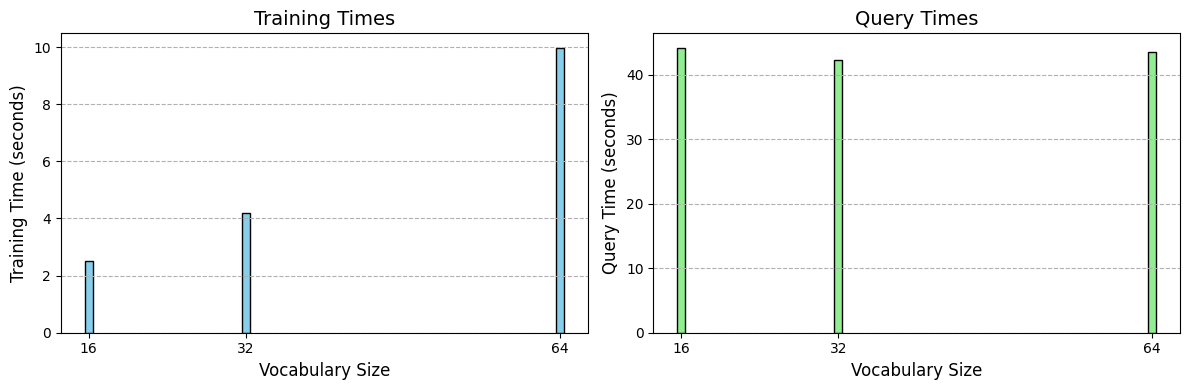

In [26]:
# Compare training times
training_times = [training_time_16c, training_time_32c, training_time_64c]
vocabulary_sizes = [16, 32, 64]

# Customize the bar chart for training times
plt.figure(figsize=(12, 4))  # Adjust the figure size

# Subplot for training times
plt.subplot(1, 2, 1)  # Create a subplot for training times
plt.bar(vocabulary_sizes, training_times, color='skyblue', edgecolor='black')
plt.xlabel('Vocabulary Size', fontsize=12)  # Customize x-axis label and fontsize
plt.ylabel('Training Time (seconds)', fontsize=12)  # Customize y-axis label and fontsize
plt.title('Training Times', fontsize=14)  # Customize title and fontsize
plt.xticks(vocabulary_sizes, fontsize=10)  # Customize x-axis tick labels fontsize
plt.yticks(fontsize=10)  # Customize y-axis tick labels fontsize
plt.grid(axis='y', linestyle='--')  # Add grid lines

# Compare query times
query_times = [query_time_16c, query_time_32c, query_time_64c]

# Subplot for query times
plt.subplot(1, 2, 2)  # Create a subplot for query times
plt.bar(vocabulary_sizes, query_times, color='lightgreen', edgecolor='black')
plt.xlabel('Vocabulary Size', fontsize=12)  # Customize x-axis label and fontsize
plt.ylabel('Query Time (seconds)', fontsize=12)  # Customize y-axis label and fontsize
plt.title('Query Times', fontsize=14)  # Customize title and fontsize
plt.xticks(vocabulary_sizes, fontsize=10)  # Customize x-axis tick labels fontsize
plt.yticks(fontsize=10)  # Customize y-axis tick labels fontsize
plt.grid(axis='y', linestyle='--')  # Add grid lines

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


**Q3**: Using the vocabulary which achieves the best performance in the previous point, analyze the effects of changing the parameters $m$ and $k$ in terms of mAP (always use multiples of 8). Some plots here can be useful to justify your answer. What about times (training and testing)? Do they vary?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Effect of m value on training time:**
The parameter m represents the number of quantizers used in the training process, with each quantizer being trained using vectors of length D / m. As we increase the value of m, the training time generally increases. This is because a higher number of quantizers requires training each quantizer separately. Training each quantizer involves performing computations such as clustering and centroid calculation. With more quantizers, the overall training process becomes more time-consuming as each quantizer needs to be trained sequentially. However, the relationship between m and training time is not strictly proportional.

**Effect of k value on training time:**
The parameter k represents the number of centroids (visual words) computed for each of the m quantizers. Similar to the effect of m, increasing the value of k generally leads to an increase in training time. With a larger number of centroids, the clustering algorithm needs to process more data points and perform more computations. The training process involves assigning data points to their nearest centroids and updating the centroids iteratively. As the number of centroids increases, the algorithm needs to process and update more centroids, resulting in increased training time.

**Trade-off between m, k, and training time:**
It is important to consider the trade-off between the parameter values (m and k) and the associated training time. Increasing both m and k generally improves the performance in terms of mAP by providing a more expressive vocabulary. However, this improvement in performance comes at the cost of increased training time. As the number of quantizers and centroids increases, the training process becomes more computationally intensive. 

**Effect of m value on mAP:**
When we increase the value of m, we are essentially increasing the granularity of the quantization. This can potentially improve the discriminative power of the resulting visual words, leading to better performance in terms of mAP. With a higher number of quantizers, the vocabulary becomes more expressive, allowing for finer distinctions between visual patterns. As a result, the retrieval system may be able to better capture the semantic similarities between images, leading to higher mAP values.

**Effect of k value on mAP:**
Increasing the value of k essentially increases the size of the vocabulary. A larger vocabulary provides more diverse visual words, allowing for a richer representation of image features. This increased diversity can lead to improved discrimination and a better ability to differentiate between images during retrieval. Consequently, increasing the value of k can positively impact mAP values by providing a more comprehensive representation of the visual patterns in the dataset.

**Trade-off between m, k, and mAP:**
There is a trade-off between the parameter values m and ) and their impact on mAP. As mentioned earlier, increasing both m and k generally improves mAP by enhancing the expressiveness and discriminative power of the vocabulary. However, this improvement comes at the cost of increased computational complexity and potentially longer retrieval times.

m value effect

In [27]:
# Variables to store results
m_values = [8, 16, 24]
mAP_values = []
training_times = []
query_times = []

# Fix k to a constant value
k = 256

# Load the fixed vocabulary
vocab = np.load('../vocabs/sift_16c.npy')

for m in m_values:
    # Describe images using VLAD with fixed vocabulary
    query_vlad = describe_images_VLAD(query_desc, vocab)
    train_vlad = describe_images_VLAD(train_desc, vocab)

    # Measure training time
    start_time = time.time()
    quantizers = pq_build_quantizers(train_vlad, m=m, k=k)
    training_time = time.time() - start_time

    # Measure query time
    start_time = time.time()
    index = pq_build_index(train_vlad, quantizers)
    query_time = time.time() - start_time

    # Measure mAP
    _, mAP = compute_mAP(query_names, query_vlad, index, train_names, quantizers)

    # Store results
    mAP_values.append(mAP)
    training_times.append(training_time)
    query_times.append(query_time)
    
    # Print the results
    print(f"mAP 16c: {mAP:.5f}")
    print(f"Training time for {m} clusters: {training_time:.3f} seconds")
    print(f"Query time for {m} clusters: {query_time:.3f} seconds")
    print()


mAP 16c: 0.37725
Training time for 8 clusters: 0.298 seconds
Query time for 8 clusters: 1.747 seconds

mAP 16c: 0.39723
Training time for 16 clusters: 0.317 seconds
Query time for 16 clusters: 1.421 seconds

mAP 16c: 0.40595
Training time for 24 clusters: 0.427 seconds
Query time for 24 clusters: 1.612 seconds



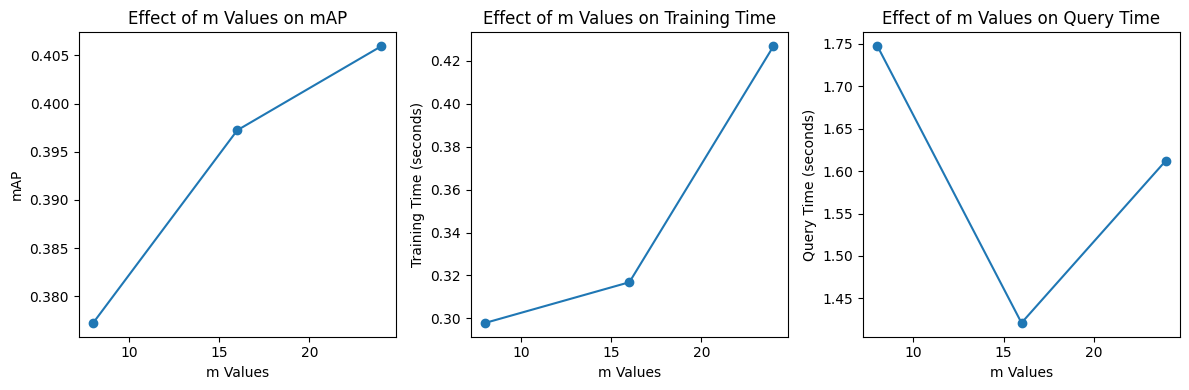

In [28]:
# Create subplots for mAP, training times, and query times
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot mAP values
axs[0].plot(m_values, mAP_values, marker='o')
axs[0].set_xlabel('m Values')
axs[0].set_ylabel('mAP')
axs[0].set_title('Effect of m Values on mAP')

# Plot training times
axs[1].plot(m_values, training_times, marker='o')
axs[1].set_xlabel('m Values')
axs[1].set_ylabel('Training Time (seconds)')
axs[1].set_title('Effect of m Values on Training Time')

# Plot query times
axs[2].plot(m_values, query_times, marker='o')
axs[2].set_xlabel('m Values')
axs[2].set_ylabel('Query Time (seconds)')
axs[2].set_title('Effect of m Values on Query Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

k value effect

In [29]:
# Variables to store results
k_values = [128, 256, 512]
mAP_values = []
training_times = []
query_times = []

# Fix m to a constant value
m = 16

# Load the fixed vocabulary
vocab = np.load('../vocabs/sift_16c.npy')

for k in k_values:
    # Describe images using VLAD with fixed vocabulary
    query_vlad = describe_images_VLAD(query_desc, vocab)
    train_vlad = describe_images_VLAD(train_desc, vocab)

    # Measure training time
    start_time = time.time()
    quantizers = pq_build_quantizers(train_vlad, m=m, k=k)
    training_time = time.time() - start_time

    # Measure query time
    start_time = time.time()
    index = pq_build_index(train_vlad, quantizers)
    query_time = time.time() - start_time

    # Measure mAP
    _, mAP = compute_mAP(query_names, query_vlad, index, train_names, quantizers)

    # Store results
    mAP_values.append(mAP)
    training_times.append(training_time)
    query_times.append(query_time)
    
    # Print the results
    print(f"mAP 16c with k={k}: {mAP:.5f}")
    print(f"Training time for k={k}: {training_time:.3f} seconds")
    print(f"Query time for k={k}: {query_time:.3f} seconds")
    print()



mAP 16c with k=128: 0.38601
Training time for k=128: 0.214 seconds
Query time for k=128: 0.925 seconds

mAP 16c with k=256: 0.39324
Training time for k=256: 0.322 seconds
Query time for k=256: 1.424 seconds

mAP 16c with k=512: 0.40085
Training time for k=512: 0.582 seconds
Query time for k=512: 2.524 seconds



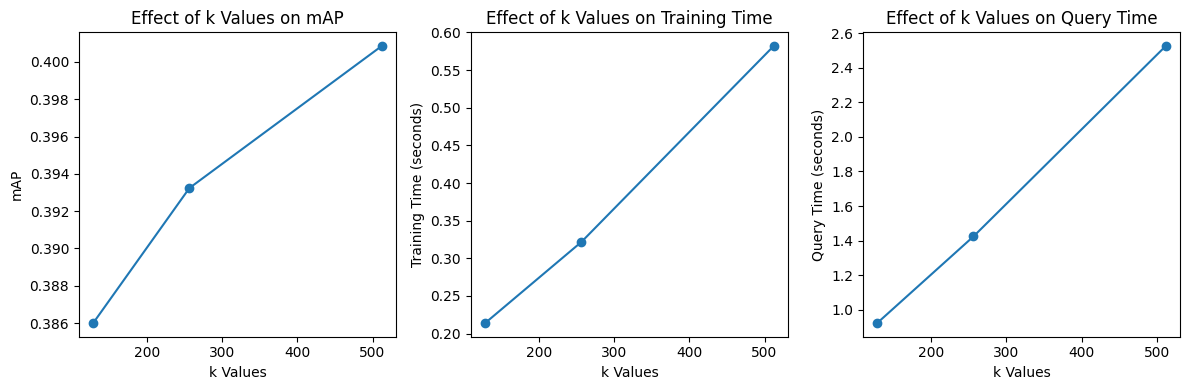

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot mAP values
axs[0].plot(k_values, mAP_values, marker='o')
axs[0].set_xlabel('k Values')
axs[0].set_ylabel('mAP')
axs[0].set_title('Effect of k Values on mAP')

# Plot training times
axs[1].plot(k_values, training_times, marker='o')
axs[1].set_xlabel('k Values')
axs[1].set_ylabel('Training Time (seconds)')
axs[1].set_title('Effect of k Values on Training Time')

# Plot query times
axs[2].plot(k_values, query_times, marker='o')
axs[2].set_xlabel('k Values')
axs[2].set_ylabel('Query Time (seconds)')
axs[2].set_title('Effect of k Values on Query Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Search Reranking
---
As a final step, you will play with a *Relevance Feedback* method. More precisely, you will write the required code to implement the **Ide Dec-Hi** algorithm. Remember that it is a simple variant of the Rocchio algorithm where only one non-relevant result is employed.

First, to implement this method, we need a way to classify an initial set of results in *relevant* and *non-relevant* for a given query. As we saw, in computer vision, this is typically carried out using geometric spatial verificacion techniques. However, in this assignment, for simplicity and to speed up the execution, we will make use of the following function that separates a list of results in *relevant* and *non-relevant* using just the name of the images:

In [20]:
def validate_results(query_name, list_of_results):
    '''
    Separate a result list into relevant and non-relevant results.
    
    - query_name: Name of the query image.
    - list_of_results: An ordered list of similar images following the format
        returned by the 'search_image' function.
  
    RETURN:
    - relevant: An ordered list of relevant images in list_of_results.
    - non-relevant: An ordered list of non-relevant images in list_of_results.
    '''
  
    relevant = []
    non_relevant = []
      
    q_imno = int(query_name[:-len(".jpg")])
  
    for res in list_of_results:
        t_imno = int(res[:-len(".jpg")])
        if np.abs(t_imno - q_imno) < 10:
            relevant.append(res)
        else:
            non_relevant.append(res)
  
    return relevant, non_relevant

Check the function using the following code:

In [21]:
# Describe images using VLAD
query_vlad = describe_images_VLAD(query_desc, vocab)
train_vlad = describe_images_VLAD(train_desc, vocab)

# Train quantizers
quants = pq_build_quantizers(train_vlad, m = 8, k = 256)

# Create an index
index = pq_build_index(train_vlad, quants)

i = 5
print(query_names[i])
r = search_image(query_vlad[i], index, quants, train_names)
print(r)
rev, nrev = validate_results(query_names[i], r)
print(rev)
print(nrev[:3])

100500.jpg
['100503.jpg', '136703.jpg', '100501.jpg', '100401.jpg', '133202.jpg', '127801.jpg', '128001.jpg', '133201.jpg', '112403.jpg', '117601.jpg', '131101.jpg', '102401.jpg', '120201.jpg', '136901.jpg', '148202.jpg', '125601.jpg', '102402.jpg', '104801.jpg', '131102.jpg', '127301.jpg', '100301.jpg', '112101.jpg', '147303.jpg', '126301.jpg', '100302.jpg', '112501.jpg', '112404.jpg', '135001.jpg', '144801.jpg', '135701.jpg', '140201.jpg', '146502.jpg', '128002.jpg', '137103.jpg', '130301.jpg', '113701.jpg', '103901.jpg', '103101.jpg', '136702.jpg', '120401.jpg', '109402.jpg', '112402.jpg', '129001.jpg', '102601.jpg', '136903.jpg', '120301.jpg', '111701.jpg', '129601.jpg', '138012.jpg', '129002.jpg', '139801.jpg', '143901.jpg', '118202.jpg', '103302.jpg', '106301.jpg', '129602.jpg', '112201.jpg', '135003.jpg', '120101.jpg', '147701.jpg', '133501.jpg', '117802.jpg', '136902.jpg', '103601.jpg', '137102.jpg', '147401.jpg', '112301.jpg', '136002.jpg', '106401.jpg', '136707.jpg', '100001.

Write a function called `compute_mAP_rf`. This function will do mainly the same as `compute_mAP`, but adding the Ide Dec-Hi algorithm as a *Relevance Feedback* method to enhance the retrieval results. For each query image:
- Perform an initial query using the original VLAD descriptor $Q_0$.
- Validate the obtained results, classifying images into *relevant* or *non-relevant*.
- If there is at least 1 *relevant* result, compute a new query vector as:
$$
Q_m = \alpha Q_0 + \beta \frac{1}{|D_r|} \displaystyle \sum_{i=1}^{|D_r|} D_r^i - \gamma D_{nr}^0\,,
$$
where $\alpha$, $\beta$ and $\gamma$ are the weights used in the algorithm, $D_r$ is the set of *relevant* images and $D_{nr}^0$ is the best *non-relevant* image (just one). Otherwise, the search is over.
- Re-query **once** using $Q_m$. This will be the final result set for this query image. You can also append the results to the original set.

Notice that we will use VLAD vectors to compute $Q_m$ and, therefore, we will need the original set (*train_descs*), since the index contains the encoded version of the database images.

In [22]:
def search_image(desc, index, quantizers, img_names):
    '''
    Search an image in the index
    
    - descs: Query VLAD vector represented as a numpy array of size (D, ).
    - index: A list where each element i is the encoded version of an image of the database.
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
    - img_names: A list of image names to associate each code in 'index' with 
        its string name in the dataset.
  
    RETURN:
      - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
    '''
    # Calculate the distances between the query vector and all images in the index
    distances = []
    for code, img_name in zip(index, img_names):
        distance = pq_distance(desc, code, quantizers)
        distances.append((img_name, distance))

    return [img_name for img_name, distance in sorted(distances, key=lambda x: x[1])]

In [29]:
def search_image(desc, index, quantizers, img_names):
    '''
    Search an image in the index
    
    - descs: Query VLAD vector represented as a numpy array of size (D, ).
    - index: A list where each element i is the encoded version of an image of the database.
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
    - img_names: A list of image names to associate each code in 'index' with 
        its string name in the dataset.
  
    RETURN:
      - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
    '''
    
    # Number of quantizers
    m = len(quantizers)    
    
    # Centrois for each quantizer
    k = quantizers[0].shape[0]
    
    # Calculate L2 distances between the query and all codes in the index
    distances = [(img_name, pq_distance(desc, code, quantizers)) for code, img_name in zip(index, img_names)]
    sorted_distances = sorted(distances, key=lambda x: x[1])
    sorted_img_names = [img_name for img_name, distance in sorted_distances]

    return sorted_img_names


In [30]:
def compute_mAP_rf(query_names, query_descs, train_names, train_descs, index, 
              quantizers, alpha = 1.0, beta = 0.75, gamma = 0.25):  
    '''
    Perform a search for a list of query images against the database, adding Ide
     Dec-Hi as a RF method.
    
    - query_names: An ordered list with the names of query images.
    - query_descs: A list containing VLAD vectors of size (D, ) we want to search.
        Each element i is a numpy array extracted from the image i.
    - train_names: A list of image names to associate each code in 'index' with 
        its name in the dataset.
    - train_descs: A list containing VLAD vectors of size (D, ) corresponding to 
        the database images.
    - index: Index of images to search the query descriptors.
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
    - alpha, beta, gamma: Ide's Dec-Hi algorithm weights.
  
    RETURN: 
    - total_results: A dictionary containing, for each query image, 
        an ordered list of the retrieved images.
    - m_ap: Mean Average Precision averaged over all queries.
    '''
    total_results = {}
    m_ap = 0.0

    for query_name, query_desc in zip(query_names, query_descs):
        # Perform initial query using the original VLAD descriptor
        initial_results = search_image(query_desc, index, quantizers, train_names)
        relevant, non_relevant = validate_results(query_name, initial_results)

        if len(relevant) > 0 and len(non_relevant) > 0:
            # Get the top non-relevant image and its VLAD descriptor
            top_non_relevant = non_relevant[0]
            top_non_relevant_index = train_names.index(top_non_relevant)
            top_non_relevant_vlad = train_vlad[top_non_relevant_index]

            # Compute the average VLAD descriptor of the relevant images
            relevant_vlad_descs = [train_vlad[train_names.index(idx)] for idx in relevant]
            avg_relevant_q = np.mean(relevant_vlad_descs, axis=0)

            # Compute the new query descriptor using Ide's Dec-Hi algorithm
            new_query_desc = (alpha * query_desc) + (beta * avg_relevant_q) - (gamma * top_non_relevant_vlad)

            # Re-query using the new query descriptor
            refined_results = search_image(new_query_desc, index, quantizers, train_names)

            # Combine the initial and refined results
            results = initial_results + refined_results
        else:
            # No refinement necessary, store the initial results
            results = initial_results

        # Store the results for the query image
        total_results[query_name] = results

    # Compute mAP using the results
    m_ap = ev.compute_mAP(total_results, gt_file='../holidays/holidays_images.dat')

    return total_results, m_ap

In [31]:
# Example of computing mAP
results, mAP = compute_mAP_rf(query_names, query_vlad, train_names[0:2], train_desc[0:2], index, quantizers)
print(results['100000.jpg'])
print(results['100100.jpg'])
print(mAP) # This should be close to 0 now, since there is only two images in the database.

['100001.jpg', '100002.jpg']
['100001.jpg', '100002.jpg']
0.002


In [154]:
# Computing mAP
results, mAP = compute_mAP_rf(query_names, query_vlad, train_names, train_desc, index, quantizers)
print(mAP)

0.4061175377643705


**Q4**: Compute the mAP obtained using this function (`compute_mAP_rf`) for different vocabularies and values of $m$ and $k$. Verify if there exists an increment of performance with regard to the same configuration without using de Dec-Hi algorithm.

Query time is significantly higher when using relevance feedback as expected since it needs to query again with the feedbak. 

In [32]:
import time

# Fill these variables with the resulting mAP
mAP_16c_rf = 0.0
mAP_32c_rf = 0.0
mAP_64c_rf = 0.0

# YOUR CODE HERE
vocab_16c = np.load('../vocabs/sift_16c.npy')
vocab_32c = np.load('../vocabs/sift_32c.npy')
vocab_64c = np.load('../vocabs/sift_64c.npy')

# Measure training times
start_time = time.time()
query_vlad_16c = describe_images_VLAD(query_desc, vocab_16c)
train_vlad_16c = describe_images_VLAD(train_desc, vocab_16c)
quants_16c = pq_build_quantizers(train_vlad_16c, m = 8, k = 256)
index_16c = pq_build_index(train_vlad_16c, quants_16c)
training_time_16c_rf = time.time() - start_time

start_time = time.time()
query_vlad_32c = describe_images_VLAD(query_desc, vocab_32c)
train_vlad_32c = describe_images_VLAD(train_desc, vocab_32c)
quants_32c = pq_build_quantizers(train_vlad_32c, m = 8, k = 256)
index_32c = pq_build_index(train_vlad_32c, quants_32c)
training_time_32c_rf = time.time() - start_time

start_time = time.time()
query_vlad_64c = describe_images_VLAD(query_desc, vocab_64c)
train_vlad_64c = describe_images_VLAD(train_desc, vocab_64c)
quants_64c = pq_build_quantizers(train_vlad_64c, m = 8, k = 256)
index_64c = pq_build_index(train_vlad_64c, quants_64c)
training_time_64c_rf = time.time() - start_time

In [33]:
# Measure query times and mAP
start_time = time.time()
train_vlad = train_vlad_16c
results_16c, mAP_16c_rf = compute_mAP_rf(query_names, query_vlad_16c, train_names, train_desc, index_16c, quants_16c)
query_time_16c_rf = time.time() - start_time

start_time = time.time()
train_vlad = train_vlad_32c
results_32c, mAP_32c_rf = compute_mAP_rf(query_names, query_vlad_32c, train_names, train_desc, index_32c, quants_32c)
query_time_32c_rf = time.time() - start_time

start_time = time.time()
train_vlad = train_vlad_64c
results_64c, mAP_64c_rf = compute_mAP_rf(query_names, query_vlad_64c, train_names, train_desc, index_64c, quants_64c)
query_time_64c_rf = time.time() - start_time

# Compare training times
print(f"Training time for 16 clusters: {training_time_16c_rf} seconds")
print(f"Training time for 32 clusters: {training_time_32c_rf} seconds")
print(f"Training time for 64 clusters: {training_time_64c_rf} seconds")

# Compare query times
print(f"Query time for 16 clusters: {query_time_16c_rf} seconds")
print(f"Query time for 32 clusters: {query_time_32c_rf} seconds")
print(f"Query time for 64 clusters: {query_time_64c_rf} seconds")

print('mAP 16c: %.5f' % mAP_16c_rf)
print('mAP 32c: %.5f' % mAP_32c_rf)
print('mAP 64c: %.5f' % mAP_64c_rf)

Training time for 16 clusters: 2.8309290409088135 seconds
Training time for 32 clusters: 4.508001804351807 seconds
Training time for 64 clusters: 10.69878888130188 seconds
Query time for 16 clusters: 87.56004500389099 seconds
Query time for 32 clusters: 82.74970388412476 seconds
Query time for 64 clusters: 84.04782581329346 seconds
mAP 16c: 0.39411
mAP 32c: 0.37257
mAP 64c: 0.31681


In [45]:
print('Map values without rf:')
print('mAP 16c: %.5f' % mAP_16c)
print('mAP 32c: %.5f' % mAP_32c)
print('mAP 64c: %.5f' % mAP_64c)

print('Map values with rf:')
print('mAP 16c: %.5f' % mAP_16c_rf)
print('mAP 32c: %.5f' % mAP_32c_rf)
print('mAP 64c: %.5f' % mAP_64c_rf)

Map values without rf:
mAP 16c: 0.37118
mAP 32c: 0.36184
mAP 64c: 0.33106
Map values with rf:
mAP 16c: 0.39411
mAP 32c: 0.37257
mAP 64c: 0.31681


Comparison of previous results without relevance feedbacck vs with relevant feedback

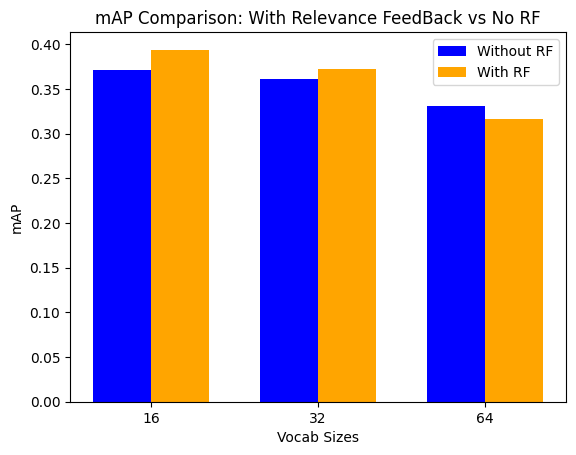

In [46]:
# Define the mAP values with and without Ide's Dec-Hi algorithm
mAP_values_no_rf = [mAP_16c, mAP_32c, mAP_64c]
mAP_values_rf = [mAP_16c_rf, mAP_32c_rf, mAP_64c_rf]

# Define the clusters for the x-axis
clusters = [16, 32, 64]

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(clusters))
r2 = [x + bar_width for x in r1]

# Plot the bar graph
plt.bar(r1, mAP_values_no_rf, color='blue', width=bar_width, label='Without RF')
plt.bar(r2, mAP_values_rf, color='orange', width=bar_width, label='With RF')

# Add labels and titles
plt.xlabel('Vocab Sizes')
plt.ylabel('mAP')
plt.title('mAP Comparison: With Relevance FeedBack vs No RF')
plt.xticks([r + bar_width / 2 for r in r1], clusters)
plt.legend()

# Show the plot
plt.show()


Based on the results, we observe that the performance increment with the Dec-Hi algorithm is evident for the 16c and 32c configurations. However, for the 64c configuration, there is a decrement in performance with a small value. Therefore, the effectiveness of the Dec-Hi algorithm appears to vary depending on the vocabulary size, indicating that it may be more beneficial for smaller vocabulary sizes.

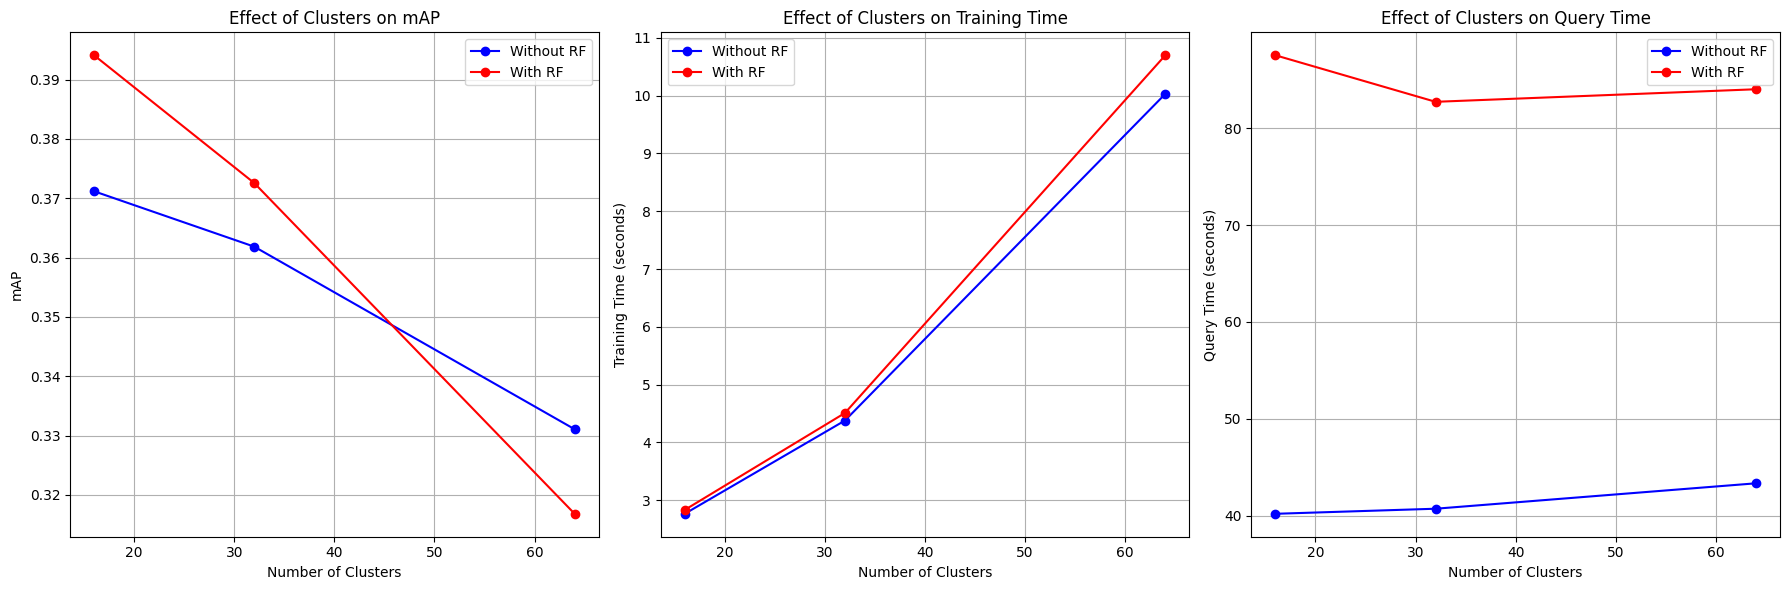

In [47]:
import matplotlib.pyplot as plt

# Define the clusters and their corresponding values without RF
clusters = [16, 32, 64]
mAP_values_without_rf = [mAP_16c, mAP_32c, mAP_64c]
training_times_without_rf = [training_time_16c, training_time_32c, training_time_64c]
query_times_without_rf = [query_time_16c, query_time_32c, query_time_64c]

# Define the clusters and their corresponding values with RF
mAP_values_with_rf = [mAP_16c_rf, mAP_32c_rf, mAP_64c_rf]
training_times_with_rf = [training_time_16c_rf, training_time_32c_rf, training_time_64c_rf]
query_times_with_rf = [query_time_16c_rf, query_time_32c_rf, query_time_64c_rf]

# Create subplots for mAP, training times, and query times
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot mAP values
axs[0].plot(clusters, mAP_values_without_rf, marker='o', label='Without RF', color='blue')
axs[0].plot(clusters, mAP_values_with_rf, marker='o', label='With RF', color='red')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('mAP')
axs[0].set_title('Effect of Clusters on mAP')
axs[0].legend()
axs[0].grid(True)

# Plot training times
axs[1].plot(clusters, training_times_without_rf, marker='o', label='Without RF', color='blue')
axs[1].plot(clusters, training_times_with_rf, marker='o', label='With RF', color='red')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Training Time (seconds)')
axs[1].set_title('Effect of Clusters on Training Time')
axs[1].legend()
axs[1].grid(True)

# Plot query times
axs[2].plot(clusters, query_times_without_rf, marker='o', label='Without RF', color='blue')
axs[2].plot(clusters, query_times_with_rf, marker='o', label='With RF', color='red')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Query Time (seconds)')
axs[2].set_title('Effect of Clusters on Query Time')
axs[2].legend()
axs[2].grid(True)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [48]:
# Define the values of m and k to iterate over
m_values = [8, 16, 24]
k_values = [128, 256, 512]

# Initialize dictionaries to store the mAP results
mAP_m_results = {}
mAP_k_results = {}

# Load the 16c vocabulary
vocab_16c = np.load('../vocabs/sift_16c.npy')

# Iterate over m values
for m in m_values:
    # Measure training time for current m value
    start_time = time.time()
    query_vlad_16c = describe_images_VLAD(query_desc, vocab_16c)
    train_vlad_16c = describe_images_VLAD(train_desc, vocab_16c)
    quants_16c = pq_build_quantizers(train_vlad_16c, m=m, k=256)
    index_16c = pq_build_index(train_vlad_16c, quants_16c)
    training_time_16c_rf = time.time() - start_time

    # Measure query time and mAP for current m value
    start_time = time.time()
    train_vlad = train_vlad_16c
    results_16c, mAP_16c_rf = compute_mAP_rf(query_names, query_vlad_16c, train_names, train_desc, index_16c, quants_16c)
    query_time_16c_rf = time.time() - start_time

    # Store the mAP result for current m value
    mAP_m_results[m] = mAP_16c_rf

# Iterate over k values
for k in k_values:
    # Measure training time for current k value
    start_time = time.time()
    query_vlad_16c = describe_images_VLAD(query_desc, vocab_16c)
    train_vlad_16c = describe_images_VLAD(train_desc, vocab_16c)
    quants_16c = pq_build_quantizers(train_vlad_16c, m=8, k=k)
    index_16c = pq_build_index(train_vlad_16c, quants_16c)
    training_time_16c_rf = time.time() - start_time

    # Measure query time and mAP for current k value
    start_time = time.time()
    train_vlad = train_vlad_16c
    results_16c, mAP_16c_rf = compute_mAP_rf(query_names, query_vlad_16c, train_names, train_desc, index_16c, quants_16c)
    query_time_16c_rf = time.time() - start_time

    # Store the mAP result for current k value
    mAP_k_results[k] = mAP_16c_rf

# Print the mAP results for different m and k values
print('mAP results for different m values:')
for m, mAP in mAP_m_results.items():
    print(f'mAP with m={m}: {mAP}')

print('\nmAP results for different k values:')
for k, mAP in mAP_k_results.items():
    print(f'mAP with k={k}: {mAP}')


mAP results for different m values:
mAP with m=8: 0.3749429230001022
mAP with m=16: 0.3946451589703633
mAP with m=24: 0.40835141697789384

mAP results for different k values:
mAP with k=128: 0.355521006262502
mAP with k=256: 0.3737045572642962
mAP with k=512: 0.37533723798550317


Effect of m values

In [52]:
mAP_m_results

{8: 0.3749429230001022, 16: 0.3946451589703633, 24: 0.40835141697789384}

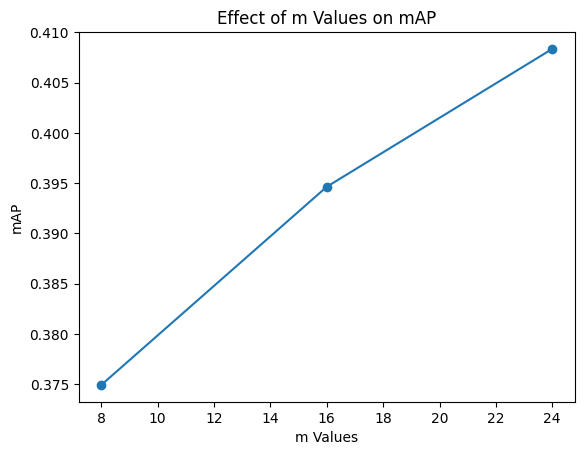

In [53]:
# Plot mAP values
plt.plot(m_values, [mAP_m_results[m] for m in m_values], marker='o')
plt.xlabel('m Values')
plt.ylabel('mAP')
plt.title('Effect of m Values on mAP')
plt.show()

Effect of k values

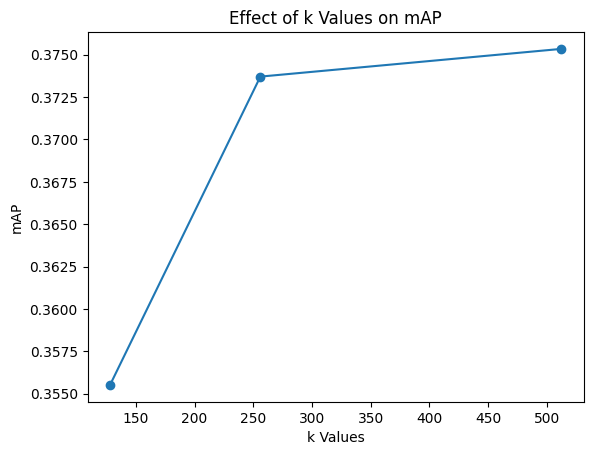

In [54]:
# Plot mAP values
plt.plot(k_values, [mAP_k_results[k] for k in k_values], marker='o')
plt.xlabel('k Values')
plt.ylabel('mAP')
plt.title('Effect of k Values on mAP')
plt.show()

Observing the mAP values, we notice an ascending trend as the value of m increases. This implies that increasing the number of centroids in the vocabulary leads to an enhancement in performance when considering mAP as the evaluation metric. The rise in mAP suggests that a larger number of centroids allows for better representation and discrimination of visual features, resulting in improved retrieval accuracy.
While there is a slight increase in mAP as k increases, the improvement is relatively modest compared to the effect of varying m.



Thus, based on these outcomes, it can be concluded that there exists a noticeable performance increment in the retrieval system when utilizing the Dec-Hi algorithm and increasing the value of m. However, the influence of k on performance appears to be comparatively minor, indicating that the choice of k has less impact on retrieval accuracy compared to the selection of m. 

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

## Submitting your work

**Important**: Please make sure that the submitted notebooks have been run and the cell outputs are visible.

**Important**: Please make also sure that you have filled the **NAME** and **DNI** variables at the beginning of the notebook, **using the indicated format**.

Once you have filled out the necessary code and you are happy with your solution, **save your notebook** and execute the following cell:

In [59]:
zip_filename = DNI + '_A3.zip'
zf = zipfile.ZipFile(zip_filename, mode = 'w')

aname = 'submitted/' + DNI + '/A3/Advanced_Techniques.ipynb'
zf.write('Advanced_Techniques.ipynb', arcname = aname);

zf.close()

This will generate a zip file of your code called `DNI_A3.zip` in the same directory of the assignment. This is the file that you must upload to [Aula Digital](https://uibdigital.uib.es/) to submit your work!

---

&copy; Emilio Garcia-Fidalgo, University of the Balearic Islands